In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

from dataset import DoubleMnist
from models import Encoder, Decoder
from train import train


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Training

In [3]:
annotations_file = "data/labels.csv"
img_dir = "data/double_mnist/"


batch_size = 1024
data = DoubleMnist(annotations_file, img_dir, device)
train_set, test_set = torch.utils.data.random_split(data, [98000, 2000])
train_dataloader = DataLoader(train_set, batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=len(test_set))

In [ ]:
encoder = Encoder()
decoder = Decoder(enc_dim=50)

encoder.to(device)
decoder.to(device)

hist_loss = train(encoder, decoder, train_dataloader, num_epochs=40)

#### Train-Test loss plot

In [42]:
encoder = Encoder()
decoder = Decoder(enc_dim=50)

encoder.to(device)
decoder.to(device)


valid_loss = []

for epoch in range(1, 40):
    checkpoint = torch.load(f"checkpoints/epoch_{epoch}.pt", map_location=device, weights_only=True)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])

    for imgs, labels in test_dataloader:
        imgs = imgs.clone().detach().float().to(device)

        img_features = encoder(imgs)
        out, alphas = decoder.forward(img_features, labels[:, :-1, :])
        loss = - torch.sum(out * labels[:, 1:, :]) / out.shape[0]
        att_reg = ((1 - alphas.sum(dim=0)) ** 2).mean()
        loss += 1 * att_reg

        valid_loss.append(loss.item())

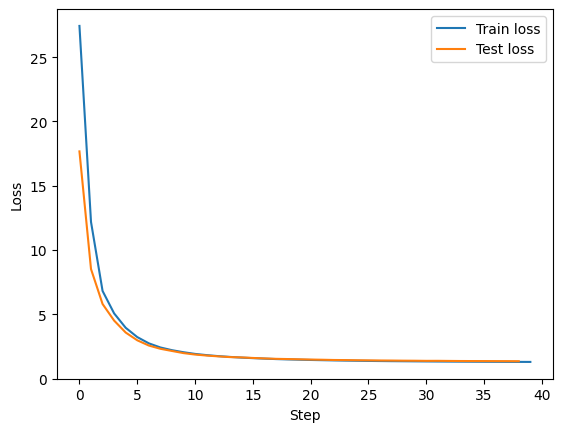

In [44]:
plt.plot(torch.tensor(hist_loss).view(40, -1).mean(dim=1), label="Train loss")
plt.plot(valid_loss, label="Test loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Attention Visualization

In [14]:
def get_caption(encoder, decoder, image):
    vocab = "abcdefghijklmnopqrstuvwxyz_"
    vocab = dict(zip(list(vocab), range(len(vocab))))
    vocab["<start>"] = 27
    vocab["<end>"] = 28
    vocab_opp = {vocab[key]: key for key in vocab}

    chars = []
    inp = torch.zeros((1, 1, 29)).to(device)
    inp[0, 0, 27] = 1  # <start>
    idx = None

    encoder.eval()
    decoder.eval()

    att_weights = []
    while idx != 28:  # <end>
        with torch.no_grad():
            img_features = encoder.forward(image.clone().detach().float())
            logits, alphas = decoder.forward(img_features, inp)

        idx = torch.argmax(logits[-1][-1], dim=-1).item()
        chars.append(vocab_opp[idx])
        att_weights.append(alphas[-1])

        x = torch.zeros((1, 1, 29)).to(device)
        x[0, 0, idx] = 1
        inp = torch.cat((inp, x), dim=1)

    return chars, att_weights

In [15]:
encoder = Encoder()
decoder = Decoder(enc_dim=50)

checkpoint = torch.load(f"checkpoints/epoch_40.pt", map_location=device, weights_only=True)
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

encoder.to(device)
decoder.to(device)

Decoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (attention): Attention(
    (W): Linear(in_features=32, out_features=128, bias=True)
    (U): Linear(in_features=50, out_features=128, bias=True)
    (v): Linear(in_features=128, out_features=1, bias=True)
    (fc_beta): Linear(in_features=50, out_features=32, bias=True)
  )
  (rnn): LSTMCell(61, 50)
  (init_h): Linear(in_features=64, out_features=50, bias=True)
  (init_c): Linear(in_features=64, out_features=50, bias=True)
  (out_fc): Linear(in_features=50, out_features=29, bias=True)
)

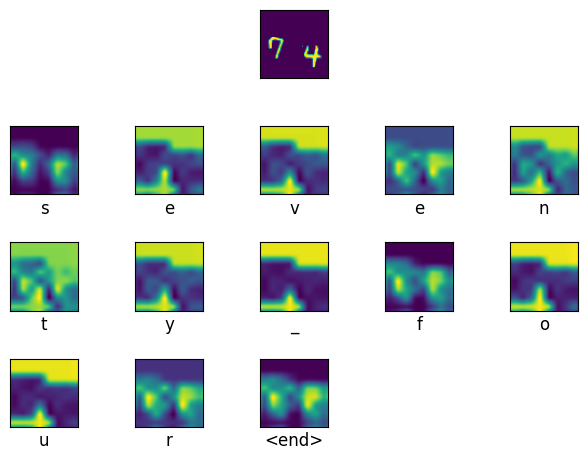

In [17]:
import matplotlib.gridspec as gridspec
import skimage

rnd = np.random.randint(1024)
image = test_dataloader.dataset[rnd][0].unsqueeze(0)

cap, weights = get_caption(encoder, decoder, image)


fig = plt.figure()
gs = gridspec.GridSpec(4, 5)

ax = fig.add_subplot(gs[0, 2])
ax.imshow(image.cpu().view(64, 64))

for r in range(1, 4):
    for c in range(5):
        idx = 5 * (r - 1) + c
        if idx < len(cap):
            ax = fig.add_subplot(gs[r, c])
            ax.imshow(
                skimage.transform.pyramid_expand(
                    weights[idx].view(8, 8).cpu(),
                    upscale=8,
                    sigma=1
                )
            )
            ax.set_title(cap[idx], y=-0.4)


plt.tight_layout()
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()